In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
from scipy import stats
import warnings
warnings.simplefilter(action='ignore')

In [3]:
df0 = pd.read_csv('E:/Datasets/brazil_sell2017.csv')

# 1. Understanding the Data

In [4]:
df0.head()

,id,created_on,property_type,place_name,state_name,price,currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms
0,3bb1d028395db8ccea222971939854becd905e23,2016-07-20,house,Bahia,Bahia,450000.0,BRL,137421.36,NaN,80,1717.767000,5625.000000,NaN,1.0
1,e45279283a0eb3b08194d7208d9647334042ae13,2017-01-31,house,Ceará,Ceará,135000.0,BRL,41473.38,NaN,76,545.702368,1776.315789,NaN,1.0
2,5f760e0e1134339ffd92933ee56fecd1810b3578,2017-01-31,house,Ceará,Ceará,440000.0,BRL,135172.49,NaN,94,1438.005213,4680.851064,NaN,2.0
3,78664e248ec3e5038663d8baf1ba1249b66b80ff,2016-09-22,house,Ceará,Ceará,850000.0,BRL,256348.39,NaN,450,569.663089,1888.888889,NaN,NaN
4,baa923172acbc0e52989326ba5358116e525fcd8,2017-01-17,house,Pernambuco,Pernambuco,115000.0,BRL,35329.17,NaN,65,543.525692,1769.230769,NaN,1.0


In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     16000 non-null  object 
 1   created_on             16000 non-null  object 
 2   property_type          16000 non-null  object 
 3   place_name             16000 non-null  object 
 4   state_name             16000 non-null  object 
 5   price                  16000 non-null  float64
 6   currency               16000 non-null  object 
 7   price_aprox_usd        16000 non-null  float64
 8   surface_total_in_m2    1685 non-null   float64
 9   surface_covered_in_m2  16000 non-null  int64  
 10  price_usd_per_m2       16000 non-null  float64
 11  price_per_m2           15997 non-null  float64
 12  floor                  1000 non-null   float64
 13  rooms                  12919 non-null  float64
dtypes: float64(7), int64(1), object(6)
memory usage: 1.7+ 

In [7]:
#DROP id, place_name, price, currency (redundant)
#MODIFY created_on: year only, price_aprox_usd > price_usd

# 2. Data Preparation

In [8]:
#DROP aforementioned columns
df1 =df0.drop(['id','place_name','price','currency'], axis=1, inplace=False)

In [9]:
#MODIFY aforementioned columns
df1.rename({'price_aprox_usd':'price_usd'}, axis=1,inplace=True)
df1['year_created'] = df1['created_on'].apply(lambda x: x.split('-')[0])
df1.drop('created_on', axis=1, inplace=True)

In [10]:
df1.head()

,property_type,state_name,price_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,year_created
0,house,Bahia,137421.36,NaN,80,1717.767000,5625.000000,NaN,1.0,2016
1,house,Ceará,41473.38,NaN,76,545.702368,1776.315789,NaN,1.0,2017
2,house,Ceará,135172.49,NaN,94,1438.005213,4680.851064,NaN,2.0,2017
3,house,Ceará,256348.39,NaN,450,569.663089,1888.888889,NaN,NaN,2016
4,house,Pernambuco,35329.17,NaN,65,543.525692,1769.230769,NaN,1.0,2017


Missing Values

In [12]:
#Check for missing values
df1.isnull().sum()

property_type                0
state_name                   0
price_usd                    0
surface_total_in_m2      14315
surface_covered_in_m2        0
price_usd_per_m2             0
price_per_m2                 3
floor                    15000
rooms                     3081
year_created                 0
dtype: int64

In [13]:
#Visualize Missing value Proportion
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

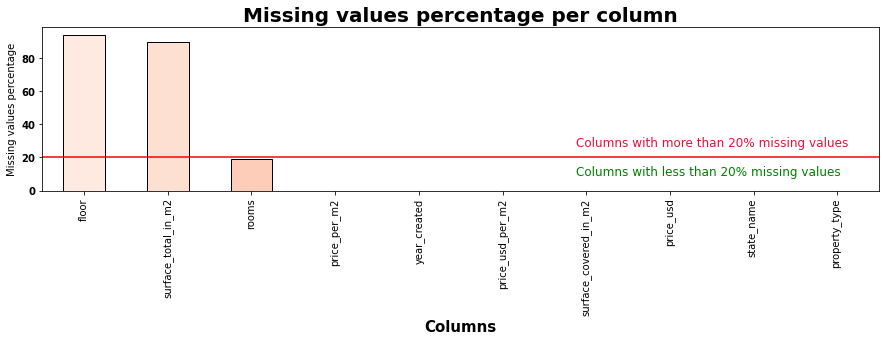

In [14]:
msv_1(df1, 20, color=sns.color_palette('Reds',15))

In [15]:
#drop floor, surface_total_m2 :too much missing data, MCAR
#fill missing data in rooms with MEAN

In [16]:
df1.drop(['floor','surface_total_in_m2'], axis=1, inplace=True)

In [17]:
#check rooms(mean)
df1.describe()

,price_usd,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms
count,1.600000e+04,16000.000000,16000.000000,15997.000000,12919.000000
mean,1.784095e+05,146.984813,1454.530467,4764.073015,1.821503
std,2.932725e+05,669.480614,4595.249906,14921.512119,1.476303
min,0.000000e+00,1.000000,0.000000,4.714286,1.000000
25%,7.373045e+04,62.000000,942.457243,3080.357143,1.000000
50%,1.112671e+05,90.000000,1209.606657,3979.591837,1.000000
75%,1.945232e+05,160.000000,1537.881387,5025.675676,2.000000
max,1.889343e+07,70000.000000,254777.070000,800000.000000,33.000000


In [20]:
#FILL missing values (room) with mean
    #round up 1.8 to 2, (rooms: definite)
df1['rooms'].fillna(2, axis=0,inplace=True)

In [19]:
df1.describe()

,price_usd,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms
count,1.600000e+04,16000.000000,16000.000000,15997.000000,16000.000000
mean,1.784095e+05,146.984813,1454.530467,4764.073015,1.855875
std,2.932725e+05,669.480614,4595.249906,14921.512119,1.328425
min,0.000000e+00,1.000000,0.000000,4.714286,1.000000
25%,7.373045e+04,62.000000,942.457243,3080.357143,1.000000
50%,1.112671e+05,90.000000,1209.606657,3979.591837,2.000000
75%,1.945232e+05,160.000000,1537.881387,5025.675676,2.000000
max,1.889343e+07,70000.000000,254777.070000,800000.000000,33.000000


In [21]:
df1.isnull().sum()

property_type            0
state_name               0
price_usd                0
surface_covered_in_m2    0
price_usd_per_m2         0
price_per_m2             3
rooms                    0
year_created             0
dtype: int64

In [22]:
#Feature Separation
df1.info()
df_num = df1[['price_usd','surface_covered_in_m2','price_usd_per_m2','rooms']]
df_cat = df1[['property_type','state_name']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_type          16000 non-null  object 
 1   state_name             16000 non-null  object 
 2   price_usd              16000 non-null  float64
 3   surface_covered_in_m2  16000 non-null  int64  
 4   price_usd_per_m2       16000 non-null  float64
 5   price_per_m2           15997 non-null  float64
 6   rooms                  16000 non-null  float64
 7   year_created           16000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1000.1+ KB


# 3. UNIVARIATE ANALYSIS

A. Numerical Features

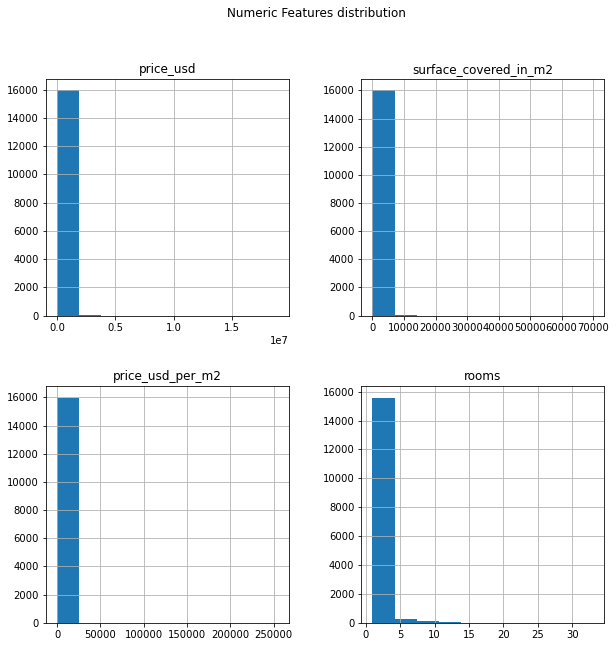

In [28]:
#  i. Center and Spread
df_num.hist(figsize=[10,10]) #set figure size
plt.suptitle("Numeric Features distribution")
plt.show() 

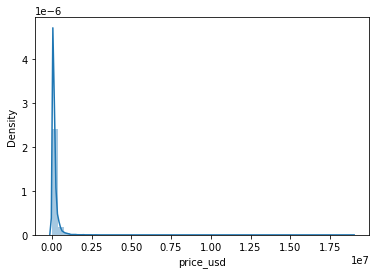

In [24]:
sns.distplot(df1['price_usd'])
plt.show()

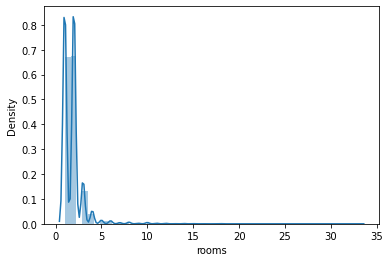

In [29]:
sns.distplot(df1['rooms'])
plt.show()

In [30]:
#Highly skewed,right

In [33]:
#  ii. Outliers         
        
def BOXP(df):
    for feature in df.columns: 
        sns.boxplot(x = feature, data =df)
        plt.show()    

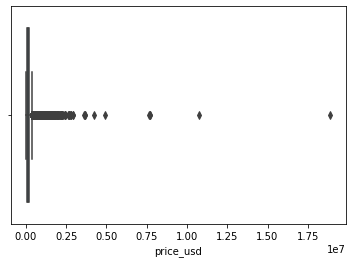

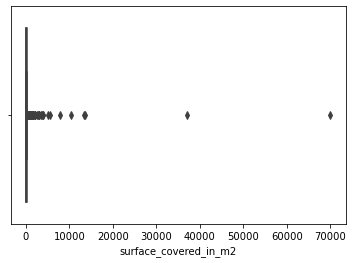

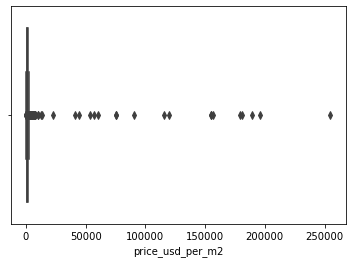

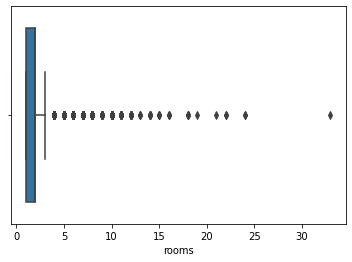

In [34]:
BOXP(df_num)

B. Categorical Features

In [36]:
#Frequency/Count
def horizontal_plot(data, column_name, color, plot_title):
    fig, ax = plt.subplots(figsize = (9, 6))
    
    title_cnt = data[column_name].value_counts().sort_values(ascending = False).reset_index()

    mn = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor = 'black', color =
                sns.color_palette(color, len(title_cnt)))

    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values 
    ax.invert_yaxis()

    ax.set_title(plot_title,weight='bold',loc='center', pad=10, fontsize=16)
    
    ax.set_xlabel('Count', weight='bold')

    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()

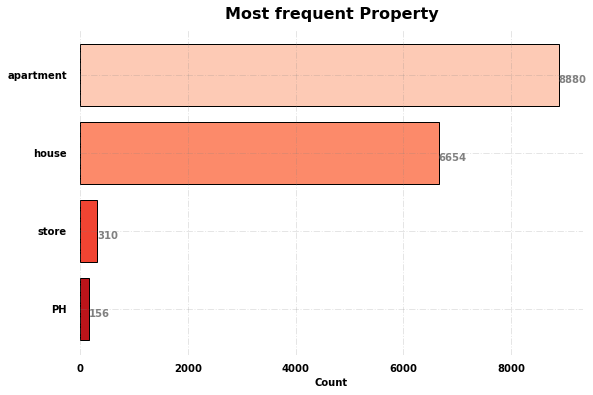

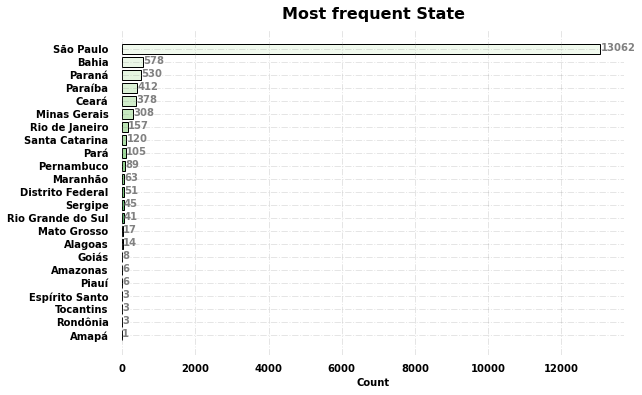

In [37]:
horizontal_plot(df_cat, 'property_type', 'Reds', 'Most frequent Property')
horizontal_plot(df_cat, 'state_name', 'Greens', 'Most frequent State')

# 4. BIVARIATE ANALYSIS

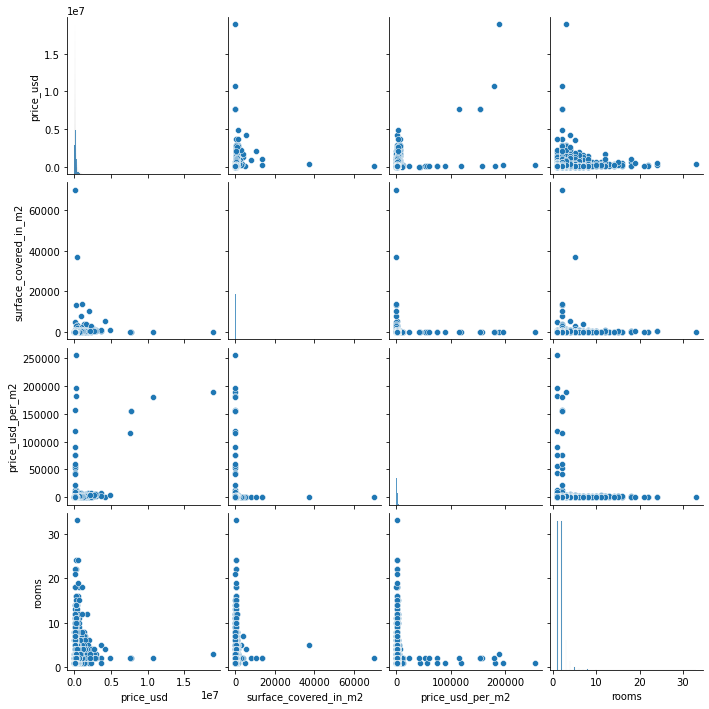

In [38]:
sns.pairplot(df_num)
plt.show()

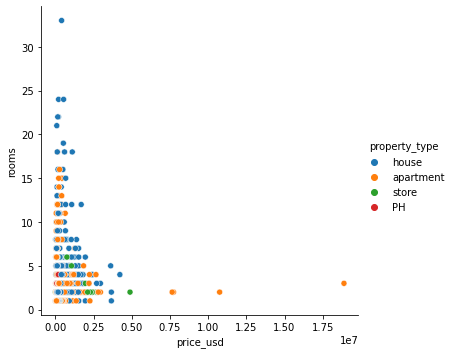

In [40]:
sns.relplot(x='price_usd',y='rooms',hue='property_type', data=df1)